$\, \text{\textbf{Python Session 1}} \, $

Through this Python session, we aim at numerically solving the following $\, \textcolor{blue}{\text{realistic}} \, $ reusable rocket landing problem:
$$
\text{OCP} \quad \begin{cases}
\displaystyle \underset{u \in L^{\infty}}{\min} \quad \int^{t_f}_0 \| u(t) \| \; \mathrm{d}t , \quad t_f \ \ \text{fixed or free} \\[2.5px]
\displaystyle \frac{d}{dt} \left(\begin{array}{c}
r \\
v \\
m
\end{array}\right)(t) = \left(\begin{array}{c}
v(t) \\
\displaystyle \frac{T_{\max}}{m(t)} u(t) - g_r \\
-q \| u(t) \|
\end{array}\right) , \quad t \in [0,t_f] \\[10px]
(r,v,m)(0) = (r_0,v_0) , \quad (r,v)(t_f) = (0,0) \\[10px]
0 < u_{\min} \le \| u(t) \| \le u_{\max} , \quad t \in [0,t_f] \\[10px]
\textcolor{blue}{r_z(t) - \tan(\gamma) \| (r_x(t),r_y(t)) \| \ge 0 , \quad t \in [0,t_f], \quad \gamma \in [0,\pi / 2).}
\end{cases}
$$
The constraints written in blue are new to the formulation and are called $\, \textcolor{blue}{\text{glide-slope constraints}} \, $: they essentially mitigate too abrupt maneuvers that may result in hazardous crashes. We proceed in three steps:
1. Get intuition on the shape of optimal controls for OCP $\, \text{\textbf{with no}} \, $ glide-slope constraints.
2. Leverage the control at Step 1. to efficiently initialize an algorithm that solves OCP $\, \text{\textbf{with no}} \, $ glide-slope constraints.
3. Leverage the control at Step 2. to efficiently solve OCP $\, \text{\textbf{with}} \, $ glide-slope constraints through continuation on these constraints.

All the considered versions of OCP will be solved through time discretization of the cost and of the different constraints (on the controls, the dynamics, etc.), and by leveraging Python finite-dimensional optimization algorithms, such as IPOPT (details are below).

$\, \textcolor{blue}{\text{For simplicity, throughout this Python session we are going to consider only the two-dimensional version of OCP, i.e., $r, v, u \in \mathbb{R}^2$ (details are below).}} \, $

$\, \textcolor{red}{\text{\textbf{Possible directions to investigate to enrich your group evaluating presentation, from easier (less points) to tougher (more points)}}} \, $

1. Correctly complete all of this Pyhton session's scripts.
2. Stress test all the approaches presented during this Python session on different scenarios, i.e., different initial conditions, different values for $u_{\min}$ and $u_{\max}$, etc.
3. Reproduce all the approaches presented during this Python session on the three-dimensional version of OCP, obtaining correct results and plots.

$\, \text{\textbf{Step 1.}} \, $

When no glide-slope constraints are imposed, the theory tells us that optimal controls are of the form:
$$
u^*(t) = \begin{cases}
\displaystyle u_{\max} \ \frac{w_1 + w_2 t}{\| w_1 + w_2 t \|} , \ \ t \in [0,t_1] \\[5px]
\displaystyle u_{\min} \frac{w_1 + w_2 t}{\| w_1 + w_2 t \|} , \ \ t \in (t_1,t_2] \\[5px]
\displaystyle u_{\max} \frac{w_1 + w_2 t}{\| w_1 + w_2 t \|} , \ \ t \in (t_2,t_f]
\end{cases} , \quad \begin{array}{c}
0 \leq t_1 \leq t_2 \leq t_f \\
w_1 , \ w_2 \in \mathbb{R}^2 .
\end{array}
$$
Therefore, we ideally only need to code a finite-dimensional optimization algorithm that seeks optimal values for $0 \leq t_1 \leq t_2 \leq t_f$ and $w_1 , \ w_2 \in \mathbb{R}^2$. Unfortunately, such an algorithm would need to cope with non-smooth cost and constraints due to $0 \leq t_1 \leq t_2 \leq t_f$, and it is therefore to avoid.

Yet, we may gain a quite good intuition on the shape of $u^*$ by guessing $0 \leq t_1 \leq t_2 \leq t_f$, running a finite-dimensional optimization algorithm that seeks optimal values for $w_1 , \ w_2 \in \mathbb{R}^2$ uniquely, and by "manually" adjusting $0 \leq t_1 \leq t_2 \leq t_f$ until convergence is (eventually) reached.

To this aim, please complete the Python script below. Try to guess different values for $0 \leq t_1 \leq t_2 \leq t_f$ until IPOPT returns "meaningful" trajectories.

Hint: look for such values in neighbors of $t_1 = 40$ and $t_2 = 60$.

In [1]:
# Basic optimization tools

import numpy as np
import matplotlib.pyplot as plt
from cyipopt import minimize_ipopt as minimize

# Scenario: landing on Mars

# Constants
gr = 3.71  # Gravity as a constant vector (m/s^2)
q = 8.4294  # Mass flow rate (kg/Ns)
Tmax = 16573.0  # Max thrust per axis (N)

# Initial and final conditions
x0, y0 = 2000.0, 1500.0  # Initial position (m)
vx0, vy0 = 100.0, -75.0  # Initial velocity (m/s)
m0 = 1905.0  # Initial mass (kg)
xf, yf = 0.0, 0.0  # Final position (m)
vxf, vyf = 0.0, 0.0  # Final velocity (m/s)

# Additional data
uMin, uMax = 0.3, 0.8  # Control bounds
mEmpty = 1000.0  # Mass lower bound (kg)

# Guess switching times
tf = 74.5  # Fixed final time (s)
t1, t2 = 40.0, 60.0  # IT'S UP TO YOU TO GUESS!

In [3]:
# Define cost and constraints within the IPOPT setting
# The optimization problem is of type
#
#    min F(X = (w1,w2)), subject to I(X) >= 0 and E(X) = 0,
#
# for some appropriate cost F, and inequality I and equality E constraints

N = 25  # Number of discretization steps

# Cost: return the time-discretized version of integral^tf_0 || u(t) || dt
def objective1(X):
    w1, w2 = X[0:2], X[2:4]
    dt = tf / (N - 1) # Discretizion time step

    # Compute the control through time as function of the
    # given t1, t2, and the optimization variable (w1,w2)
    ux = np.zeros(N-1)
    uy = np.zeros(N-1)
    constraints = []
    
    for i in range(N-1):
        # COMPLETE THE CODE

    # Return the time-discretized version of integral^tf_0 || u(t) || dt
    u_norm = 0.0
    for i in range(N-1):
        u_norm = # COMPLETE THE CODE

    return u_norm

# Inequality constraints: return the time-discretized version of the constraint
#    m(t) >= mEmpty, for all t in [0,tf]
# Note that the constraint uMin <= || u(t) || <= uMax is already encoded in the shape of u given above
def ineq_constraints1(X):
    w1, w2 = X[0:2], X[2:4]
    dt = tf / (N - 1) # Discretizion time step

    # Compute the control through time as function of the
    # given t1, t2, and the optimization variable (w1,w2)
    m = m0*np.ones(N)
    ux = np.zeros(N-1)
    uy = np.zeros(N-1)
    constraints = []

    for i in range(N-1):
        # COMPLETE THE CODE

    # Return the constraint m(t) >= mEmpty, for all t in [0,tf]
    for i in range(N-1):
        m[i+1] = # COMPLETE THE CODE
        constraints.append(m[i+1] - mEmpty)
    
    return np.array(constraints)

# Equality constraints: return the time-discretized version of the constraint
#    (x,y)(tf) = (0,0) and (vx,vy)(tf) = (0,0)
# made of final conditions on the state
def eq_constraints1(X):
    w1, w2 = X[0:2], X[2:4]
    dt = tf / (N - 1) # Discretizion time step

    # Compute the control through time as function of the
    # given t1, t2, and the optimization variable (w1,w2)
    x = x0*np.ones(N)
    y = y0*np.ones(N)
    vx = vx0*np.ones(N)
    vy = vy0*np.ones(N)
    m = m0*np.ones(N)
    ux = np.zeros(N-1)
    uy = np.zeros(N-1)
    constraints = []

    for i in range(N-1):
        # COMPLETE THE CODE

    # Return the dynamics through an explicit Euler scheme
    for i in range(N-1):
        x[i+1] = # COMPLETE THE CODE
        y[i+1] = # COMPLETE THE CODE
        vx[i+1] = # COMPLETE THE CODE
        vy[i+1] = # COMPLETE THE CODE
        m[i+1] = # COMPLETE THE CODE

    # Return the constraint made of final conditions on the state
    constraints.append(x[-1] - xf)
    constraints.append(y[-1] - yf)
    constraints.append(vx[-1] - vxf)
    constraints.append(vy[-1] - vyf)
    
    return np.array(constraints)

In [5]:
# Solve for (w1,w2)

# Initial guess for (w1,w2)
initial_guess1 = np.concatenate([
    [1.0, 0.0], 
    [0.0, 1.0] ])

# Solve with IPOPT: note that we relax the constraint violation tolerance,
# given that the artifical problem min F(w1,w2) is likely "slightly" infeasible
solution1 = minimize(objective1, initial_guess1, 
                     constraints=[{'type': 'ineq', 'fun': ineq_constraints1}, {'type': 'eq', 'fun': eq_constraints1}], 
                     options={'print_level': 5, 'max_iter': 100,
                              'acceptable_tol': 1e-2, 'tol': 1e-2, 'dual_inf_tol': 1e-2, 'constr_viol_tol': 1e1 })


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:       16
Number of nonzeros in inequality constraint Jacobian.:       96
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        4
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        4
Total number of inequality c

Total Control Effort (Cost Value): 47.1833



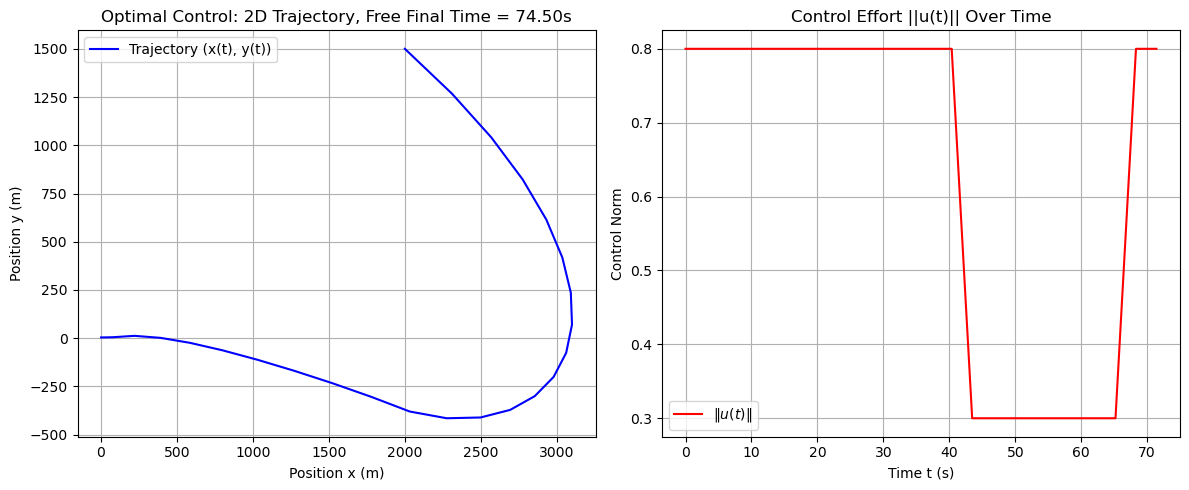

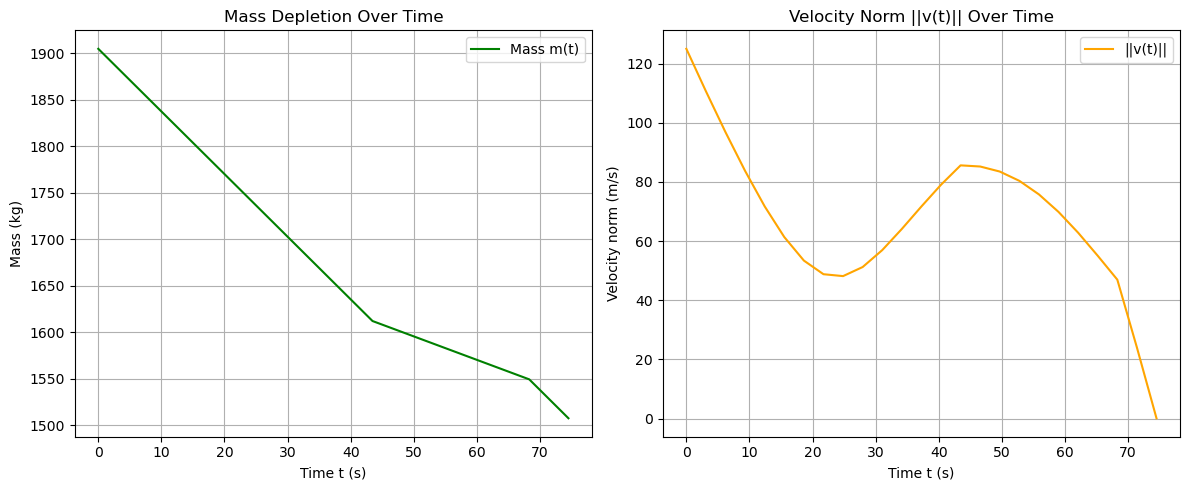

In [7]:
#Extract and plot the solution

X1 = solution1.x
w1_opt, w2_opt = X1[0:2], X1[2:4]
dt = tf / (N - 1)

x_opt1 = x0*np.ones(N)
y_opt1 = y0*np.ones(N)
vx_opt1 = vx0*np.ones(N)
vy_opt1 = vy0*np.ones(N)
m_opt1 = m0*np.ones(N)
ux_opt1 = np.zeros(N-1)
uy_opt1 = np.zeros(N-1)

# Compute the optimal controls ux_opt1 and uy_opt1 as function of the time
for i in range(N-1):
    # COMPLETE THE CODE

for i in range(N-1):
    x_opt1[i+1] = # COMPLETE THE CODE
    y_opt1[i+1] = # COMPLETE THE CODE
    vx_opt1[i+1] = # COMPLETE THE CODE
    vy_opt1[i+1] = # COMPLETE THE CODE
    m_opt1[i+1] = # COMPLETE THE CODE

# Compute control norm u_norm
u_norm1 = np.zeros(N-1)
for i in range(N-1):
    u_norm1[i] = # COMPLETE THE CODE

# Compute velocity norm v_norm
v_norm1 = np.zeros(N)
for i in range(N):
    v_norm1[i] = # COMPLETE THE CODE

# Time vector
t1 = np.linspace(0, tf, N)

# Print cost value
total_control_effort1 = np.sum(u_norm1 * dt)  # Euler sum approximation
print(f"Total Control Effort (Cost Value): {total_control_effort1:.4f}\n")

plt.figure(figsize=(12, 5))

# Plot trajectory
plt.subplot(1, 2, 1)
plt.plot(x_opt1, y_opt1, label='Trajectory (x(t), y(t))', color='blue')
plt.xlabel('Position x (m)')
plt.ylabel('Position y (m)')
plt.title(f'Optimal Control: 2D Trajectory, Free Final Time = {tf:.2f}s')
plt.grid(True)
plt.legend()

# Plot control norm ||u(t)||
plt.subplot(1, 2, 2)
plt.plot(t1[:-1], u_norm1, label=r'$\| u(t) \|$', color='red')
plt.xlabel('Time t (s)')
plt.ylabel('Control Norm')
plt.title('Control Effort ||u(t)|| Over Time')
plt.grid(True)
plt.legend()

# Show both plots
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))

# Plot mass over time
plt.subplot(1, 2, 1)
plt.plot(t1, m_opt1, label='Mass m(t)', color='green')
plt.xlabel('Time t (s)')
plt.ylabel('Mass (kg)')
plt.title('Mass Depletion Over Time')
plt.grid(True)
plt.legend()

# Plot velocity over time
plt.subplot(1, 2, 2)
plt.plot(t1, v_norm1, label='||v(t)||', color='orange')
plt.xlabel('Time t (s)')
plt.ylabel('Velocity norm (m/s)')
plt.title('Velocity Norm ||v(t)|| Over Time')
plt.grid(True)
plt.legend()

# Show both plots
plt.tight_layout()
plt.show()

$\, \text{\textbf{Step 2.}} \, $

By always assuming no glide-slope constraints are imposed, we now turn to solving OCP from scratch, i.e., without guessing the shape of optimal controls. Our goal is twofold: on the one hand, we want to experimentally check that optimal controls actually take the theoretically deduced bang-bang shape, and on the other hand, we want to stress-test convergence via efficient and inefficient control initializations.

To this aim, please complete the Python script below. Make IPOPT achieve convergence.

In [9]:
# Basic optimization tools

import numpy as np
import matplotlib.pyplot as plt
from cyipopt import minimize_ipopt as minimize

# Scenario: landing on Mars

# Constants
gr = 3.71  # Gravity as a constant vector (m/s^2)
q = 8.4294  # Mass flow rate (kg/Ns)
Tmax = 16573.0  # Max thrust per axis (N)

# Initial and final conditions
x0, y0 = 2000.0, 1500.0  # Initial position (m)
vx0, vy0 = 100.0, -75.0  # Initial velocity (m/s)
m0 = 1905.0  # Initial mass (kg)
xf, yf = 0.0, 0.0  # Final position (m)
vxf, vyf = 0.0, 0.0  # Final velocity (m/s)

# Additional data
uMin, uMax = 0.3, 0.8  # Control bounds
mEmpty = 1000.0  # Mass lower bound (kg)

# Final time
tf = 74.5  # Fixed final time (s)

In [11]:
# Define cost and constraints within the IPOPT setting
# The optimization problem is of type
#
#    min F(X = (x,y,vx,vy,m,ux,uy)), subject to I(X) >= 0 and E(X) = 0,
#
# for some appropriate cost F, and inequality I and equality E constraints

N = 25  # Number of discretization steps

# Cost: return the time-discretized version of integral^tf_0 || u(t) || dt
def objective2(X):
    # Extract variables, of type X = (x,y,vx,vy,m,ux,uy)
    x, y = X[0:N], X[N:2*N]
    vx, vy = X[2*N:3*N], X[3*N:4*N]
    m = X[4*N:5*N]
    ux, uy = X[5*N:6*N-1], X[6*N-1:]
    dt = tf / (N - 1) # Discretizion time step
    
    # Return the time-discretized version of integral^tf_0 || u(t) || dt
    u_norm = 0.0
    for i in range(N-1):
        u_norm = # COMPLETE THE CODE

    return u_norm

# Inequality constraints: return the time-discretized version of the constraints
#    m(t) >= mEmpty   and   uMin <= || u(t) || <= uMax, for all t in [0,tf]
def ineq_constraints2(X):
    # Extract variables, of type X = (x,y,vx,vy,m,ux,uy)
    x, y = X[0:N], X[N:2*N]
    vx, vy = X[2*N:3*N], X[3*N:4*N]
    m = X[4*N:5*N]
    ux, uy = X[5*N:6*N-1], X[6*N-1:]
    dt = tf / (N - 1) # Discretizion time step
    constraints = []

    # Return the constraint m(t) >= mEmpty, for all t in [0,tf]
    for i in range(N):
        constraints.append(# COMPLETE THE CODE
        )

    # Return the constraint uMin <= || u(t) || <= uMax, for all t in [0,tf]
    for i in range(N-1):
        constraints.append(# COMPLETE THE CODE
        )
        constraints.append(# COMPLETE THE CODE
        )
    
    return np.array(constraints)

# Equality constraints: return the time-discretized version of the constraints
#    (x,y,vx,vy)(0) = (x0,y0,vx0,vy0) and (x,y,vx,vy)(tf) = (0,0,0,0)
# made of intial and final conditions on the state
def eq_constraints2(X):
    # Extract variables, of type X = (x,y,vx,vy,m,ux,uy)
    x, y = X[0:N], X[N:2*N]
    vx, vy = X[2*N:3*N], X[3*N:4*N]
    m = X[4*N:5*N]
    ux, uy = X[5*N:6*N-1], X[6*N-1:]
    dt = tf / (N - 1) # Discretizion time step
    constraints = []

    # Compute the dynamics through an explicit Euler scheme
    for i in range(N-1):
        constraints.append(x[i+1] - # COMPLETE THE CODE
                          )
        constraints.append(y[i+1] - # COMPLETE THE CODE
                          )
        constraints.append(vx[i+1] - # COMPLETE THE CODE
                          )
        constraints.append(vy[i+1] - # COMPLETE THE CODE
                          )
        constraints.append(m[i+1] - # COMPLETE THE CODE
                          )

    # Return the constraint made of initial conditions on the state
    constraints.append(x[0] - x0)
    constraints.append(y[0] - y0)
    constraints.append(vx[0] - vx0)
    constraints.append(vy[0] - vy0)
    constraints.append(m[0] - m0)
    
    # Return the constraint made of final conditions on the state
    constraints.append(x[-1] - xf)
    constraints.append(y[-1] - yf)
    constraints.append(vx[-1] - vxf)
    constraints.append(vy[-1] - vyf)
    
    return np.array(constraints)

In [15]:
# Solve for (x,y,vx,vy,m,ux,uy)
# Do you observe the bang-bang shape of optimal controls?
# Do you observe improved convergence when considering the more efficient informed initialization from Step 1.?

# Uninformed (dummy) initial guess for (x,y,vx,vy,m,ux,uy) through time
initial_guess2 = np.concatenate([
    x0 * np.ones(N), y0 * np.ones(N), 
    vx0 * np.ones(N), vy0 * np.ones(N), 
    m0 * np.ones(N),
    (uMin / np.sqrt(2.0)) * np.ones(N-1), (uMin / np.sqrt(2.0)) * np.ones(N-1) ])

# Informed (efficient) initial guess for (x,y,vx,vy,m,ux,uy) through time, from Step 1.
initial_guess2 = np.concatenate([
    # COMPLETE THE CODE
    ])

# Solve with IPOPT
solution2 = minimize(objective2, initial_guess2, 
                     constraints=[{'type': 'ineq', 'fun': ineq_constraints2}, {'type': 'eq', 'fun': eq_constraints2}], 
                     options={'print_level': 5, 'max_iter': 500,
                              'acceptable_tol': 1e-2, 'tol': 1e-2, 'dual_inf_tol': 1e-2, 'constr_viol_tol': 1e-2 })

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:    22317
Number of nonzeros in inequality constraint Jacobian.:    12629
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      173
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      129
Total number of inequality constraints...............:       73
        inequality constraints with only lower bounds:       73
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.7183333e+01 4.07e+00 9.44e-02   0.0 0.00e+00    -  0.00e+00 0.00e+00 

Total Control Effort (Cost Value): 47.1579


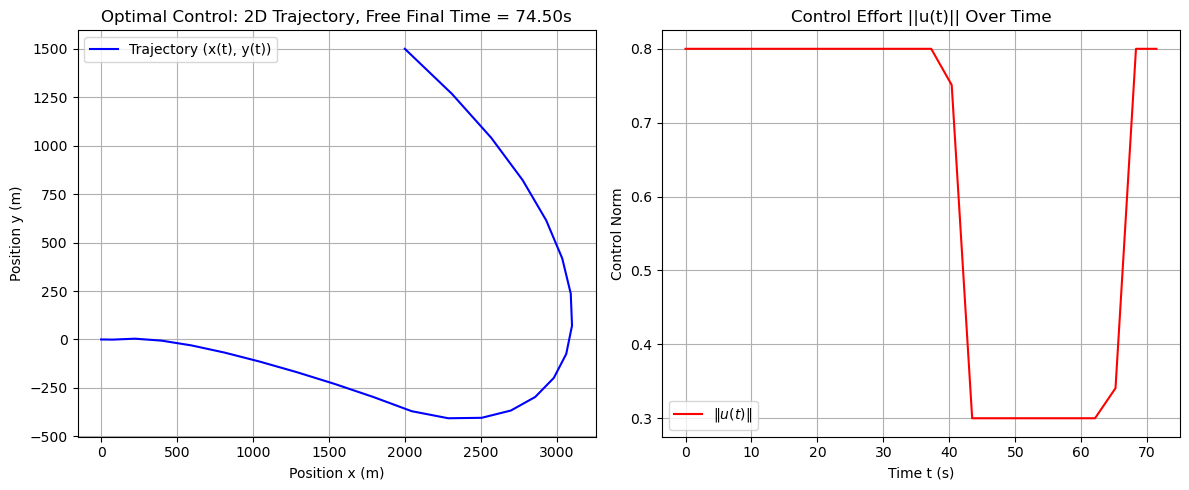

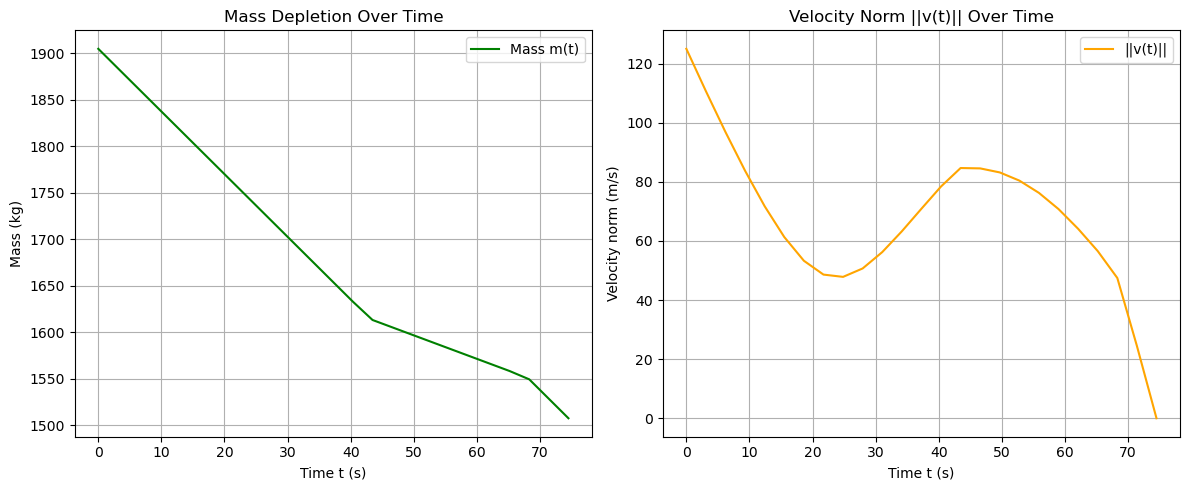

In [17]:
#Extract and plot the solution

X2 = solution2.x
x_opt2 = X2[0:N]
y_opt2 = X2[N:2*N]
vx_opt2 = X2[2*N:3*N]
vy_opt2 = X2[3*N:4*N]
m_opt2 = X2[4*N:5*N]
ux_opt2 = X2[5*N:6*N-1]
uy_opt2 = X2[6*N-1:]
dt = tf / (N - 1)

# Compute control norm u_norm
u_norm2 = np.zeros(N-1)
for i in range(N-1):
    u_norm2[i] = # COMPLETE THE CODE

# Compute velocity norm v_norm
v_norm2 = np.zeros(N)
for i in range(N):
    v_norm2[i] = # COMPLETE THE CODE

# Print cost value
total_control_effort2 = np.sum(u_norm2 * dt)  # Euler sum approximation
print(f"Total Control Effort (Cost Value): {total_control_effort2:.4f}")

# Time vector
t2 = np.linspace(0, tf, N)

plt.figure(figsize=(12, 5))

# Plot trajectory
plt.subplot(1, 2, 1)
plt.plot(x_opt2, y_opt2, label='Trajectory (x(t), y(t))', color='blue')
plt.xlabel('Position x (m)')
plt.ylabel('Position y (m)')
plt.title(f'Optimal Control: 2D Trajectory, Free Final Time = {tf:.2f}s')
plt.grid(True)
plt.legend()

# Plot control norm ||u(t)||
plt.subplot(1, 2, 2)
plt.plot(t2[:-1], u_norm2, label=r'$\| u(t) \|$', color='red')
plt.xlabel('Time t (s)')
plt.ylabel('Control Norm')
plt.title('Control Effort ||u(t)|| Over Time')
plt.grid(True)
plt.legend()

# Show both plots
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))

# Plot mass over time
plt.subplot(1, 2, 1)
plt.plot(t2, m_opt2, label='Mass m(t)', color='green')
plt.xlabel('Time t (s)')
plt.ylabel('Mass (kg)')
plt.title('Mass Depletion Over Time')
plt.grid(True)
plt.legend()

# Plot velocity over time
plt.subplot(1, 2, 2)
plt.plot(t2, v_norm2, label='||v(t)||', color='orange')
plt.xlabel('Time t (s)')
plt.ylabel('Velocity norm (m/s)')
plt.title('Velocity Norm ||v(t)|| Over Time')
plt.grid(True)
plt.legend()

# Show both plots
plt.tight_layout()
plt.show()

$\, \text{\textbf{Step 3.}} \, $

Now we turn to the original problem, i.e., subject to glide-slope constraints. The first script below, that you need to complete, shows that even when initializing with the informed (efficient) guess solution from Step 2. many iterations might be required to make the solver converge (it might not even converge!).

As a final task for this Python session, we solve the original problem by implementing an alternative continuation method. Continuation methods solve difficult problems by first transforming them into simpler ones that are easier to handle. Starting with a relaxed version of the original problem, e.g., our original OCP subject to glide-slope constraints, they gradually introduce the full complexity through a sequence of intermediate problems. Each step builds upon the previous solution, ensuring numerical stability and convergence. Please, implement the following steps in the Python scripts below to make IPOPT achieve convergence:
1. The "easier problem": solve OCP subject to glide-slope constraints but with $\ \gamma = 0 \ $, by initializing with the solution from Step 2.
2. The "continuation step": iteratively solve versions of OCP subject to glide-slope constraints for increeasing values of $\ \gamma \ $, by initializing with the solution obtained at the previous step.

In [19]:
# Basic optimization tools

import numpy as np
import matplotlib.pyplot as plt
from cyipopt import minimize_ipopt as minimize

# Scenario: landing on Mars

# Constants
gr = 3.71  # Gravity as a constant vector (m/s^2)
q = 8.4294  # Mass flow rate (kg/Ns)
Tmax = 16573.0  # Max thrust per axis (N)

# Initial and final conditions
x0, y0 = 2000.0, 1500.0  # Initial position (m)
vx0, vy0 = 100.0, -75.0  # Initial velocity (m/s)
m0 = 1905.0  # Initial mass (kg)
xf, yf = 0.0, 0.0  # Final position (m)
vxf, vyf = 0.0, 0.0
# Final velocity (m/s)

# Additional data
uMin, uMax = 0.3, 0.8  # Control bounds
mEmpty = 1000.0  # Mass lower bound (kg)
tfMin = 10.0  # Lower bound on the final time (s)

In [21]:
# Define cost and constraints within the IPOPT setting
# The optimization problem is of type
#
#    min F(X = (x,y,vx,vy,m,ux,uy,tf)), subject to I(X) >= 0 and E(X) = 0,
#
# for some appropriate cost F, and inequality I and equality E constraints
# Note: we make gamma (see the glide-slope constraint) appear as a parameter
#       that enters cost and constraints. Such trick will be key later, see the next blocks.

N = 25  # Number of discretization steps

# Cost: return the time-discretized version of integral^tf_0 || u(t) || dt
def objective3(X):
    # Extract variables, of type X = (x,y,vx,vy,m,ux,uy,tf)
    x, y = X[0:N], X[N:2*N]
    vx, vy = X[2*N:3*N], X[3*N:4*N]
    m = X[4*N:5*N]
    ux, uy = X[5*N:6*N-1], X[6*N-1:-1]
    tf = X[-1] # Extract free final time
    dt = tf / (N - 1) # Discretizion time step
    
    # Return the time-discretized version of integral^tf_0 || u(t) || dt
    u_norm = 0.0
    for i in range(N-1):
        u_norm = # COMPLETE THE CODE

    return u_norm

# Inequality constraints: return the time-discretized version of the constraints
#    m(t) >= mEmpty,   uMin <= || u(t) || <= uMax   and   y(t) - tan(gamma)*|x(t)| >= 0, for all t in [0,tf]
def ineq_constraints3(X, gammaPar):
    # Extract variables, of type X = (x,y,vx,vy,m,ux,uy,tf)
    x, y = X[0:N], X[N:2*N]
    vx, vy = X[2*N:3*N], X[3*N:4*N]
    m = X[4*N:5*N]
    ux, uy = X[5*N:6*N-1], X[6*N-1:-1]
    tf = X[-1] # Extract free final time
    dt = tf / (N - 1) # Discretizion time step
    constraints = []

    # Make sure the final time is always meaningful
    constraints.append(tf - tfMin)
    
    # Return the constraint m(t) >= mEmpty, for all t in [0,tf]
    for i in range(N):
        constraints.append(# COMPLETE THE CODE
        )

    # Return the constraint uMin <= || u(t) || <= uMax, for all t in [0,tf]
    for i in range(N-1):
        constraints.append(# COMPLETE THE CODE
        )
        constraints.append(# COMPLETE THE CODE
        )

    # Return the constraint y(t) - tan(gamma)*|x(t)| >= 0, for all t in [0,tf]
    for i in range(N):
        constraints.append(y[i] - # COMPLETE THE CODE
                          )
    
    return np.array(constraints)

# Equality constraints: return the time-discretized version of the constraints
#    (x,y,vx,vy)(0) = (x0,y0,vx0,vy0) and (x,y,vx,vy)(tf) = (0,0,0,0)
# made of intial and final conditions on the state
def eq_constraints3(X):
    # Extract variables, of type X = (x,y,vx,vy,m,ux,uy,tf)
    x, y = X[0:N], X[N:2*N]
    vx, vy = X[2*N:3*N], X[3*N:4*N]
    m = X[4*N:5*N]
    ux, uy = X[5*N:6*N-1], X[6*N-1:-1]
    tf = X[-1] # Extract free final time
    dt = tf / (N - 1) # Discretizion time step
    constraints = []

    # Compute the dynamics through an explicit Euler scheme
    for i in range(N-1):
        constraints.append(x[i+1] - # COMPLETE THE CODE
                          )
        constraints.append(y[i+1] - # COMPLETE THE CODE
                          )
        constraints.append(vx[i+1] - # COMPLETE THE CODE
                          )
        constraints.append(vy[i+1] - # COMPLETE THE CODE
                          )
        constraints.append(m[i+1] - # COMPLETE THE CODE
                          )

    # Return the constraint made of initial conditions on the state
    constraints.append(x[0] - x0)
    constraints.append(y[0] - y0)
    constraints.append(vx[0] - vx0)
    constraints.append(vy[0] - vy0)
    constraints.append(m[0] - m0)
    
    # Return the constraint made of final conditions on the state
    constraints.append(x[-1] - xf)
    constraints.append(y[-1] - yf)
    constraints.append(vx[-1] - vxf)
    constraints.append(vy[-1] - vyf)
    
    return np.array(constraints)

In [61]:
# Solve for (x,y,vx,vy,m,ux,uy)
# Do you observe convergence even when considering the more efficient informed initialization from Step 2.?

# Original value for gamma (see glide-slope constraint)
gammaOriginal = np.pi / 28.0  # Realistic 6.5 degrees (roughly)

# Informed (supposedly efficient) initial guess for (x,y,vx,vy,m,ux,uy) through time, from Step 2.
initial_guess3 = np.concatenate([
    # COMPLETE THE CODE
    [# COMPLETE THE CODE
    ] ])  # Guess for the free final time, from Step 2.

# Solve with IPOPT
# Note: due to performance constraints, no
#       more than 1000 iterations are allowed!
solution3 = minimize(objective3, initial_guess3, 
                     constraints=[{'type': 'ineq', 'fun': lambda X: ineq_constraints3(X, gammaOriginal)}, # Pass gamma as a parameter
                                  {'type': 'eq', 'fun': eq_constraints3}],
                     options={'print_level': 5, 'max_iter': 1000,
                              'acceptable_tol': 1e-2, 'tol': 1e-2, 'dual_inf_tol': 1e-2, 'constr_viol_tol': 1e-2 })

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:    22446
Number of nonzeros in inequality constraint Jacobian.:    17226
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      174
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      129
Total number of inequality constraints...............:       99
        inequality constraints with only lower bounds:       99
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.7157906e+01 7.01e+02 8.97e-01   0.0 0.00e+00    -  0.00e+00 0.00e+00 

KeyboardInterrupt: 

In [73]:
# Solve for (x,y,vx,vy,m,ux,uy)

# Solution: we develop a "continuation-based scheme". Specifically, we start by solving the problem
# for gamma = 0 (see the glide-slope constraint) with the informed initial guess for (x,y,vx,vy,m,ux,uy)
# through time from Step 2. Then, we make gamma iteratively increase towards the desired value with the
# solution at the previous step as informed initialization.

gammaOriginal = np.pi / 28.0  # Ralistic 6.5 degrees (roughly)
continuationSteps = 10  # A total number of continuationSteps continuation iterations

# Initialization of the continuation-based scheme
gamma = 0.0
continuationDelta = gammaOriginal / continuationSteps
initial_guess3 = np.concatenate([ # Informed (supposedly efficient) first initial guess
    # COMPLETE THE CODE           # for (x,y,vx,vy,m,ux,uy) through time, from Step 2.
    [# COMPLETE THE CODE
    ] ])  # Guess for the free final time, from Step 2.

# Solve with IPOPT once
# Note: due to performance constraints, no more than 1000
#       optimization iterations per continuation step are allowed!
solution3 = minimize(objective3, initial_guess3, 
                     constraints=[{'type': 'ineq', 'fun': lambda X: ineq_constraints3(X, gamma)}, # Pass gamma as a parameter
                                  {'type': 'eq', 'fun': eq_constraints3}],
                     options={'print_level': 5, 'max_iter': 500,
                              'acceptable_tol': 1e-2, 'tol': 1e-2, 'dual_inf_tol': 1e-2, 'constr_viol_tol': 1e-2 })

# Improve initial guess with solution at the previous step
initial_guess3 = # COMPLETE THE CODE

# Update the value of gamma
gamma = # COMPLETE THE CODE

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:    22446
Number of nonzeros in inequality constraint Jacobian.:    17226
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      174
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      129
Total number of inequality constraints...............:       99
        inequality constraints with only lower bounds:       99
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.7157906e+01 4.07e+02 8.99e-01   0.0 0.00e+00    -  0.00e+00 0.00e+00 

In [75]:
# Continuation loop

for i in range(continuationSteps):

    # Solve with IPOPT
    # Note: due to performance constraints, no more than 500
    #       optimization iterations per continuation step are allowed!
    solution3 = minimize(objective3, initial_guess3, 
                         constraints=[{'type': 'ineq', 'fun': lambda X: ineq_constraints3(X, gamma)}, # Pass gamma as a parameter
                                      {'type': 'eq', 'fun': eq_constraints3}],
                         options={'print_level': 5, 'max_iter': 500,
                                  'acceptable_tol': 1e-2, 'tol': 1e-2, 'dual_inf_tol': 1e-2, 'constr_viol_tol': 1e-2 })

    # Abort continuation if unsuccessful
    if solution3.success == False:
        break

    # Print information at current iteration
    print(f"\n Iteration = {i + 1:.4f}/{continuationSteps:.4f},   Solved for gamma = {gamma:.4f} (Goal: gamma = {gammaOriginal:.4f})\n")

    # Improve initial guess with solution at the previous step
    initial_guess3 = # COMPLETE THE CODE

    # Update the value of gamma
    gamma = # COMPLETE THE CODE

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:    22446
Number of nonzeros in inequality constraint Jacobian.:    17226
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      174
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      129
Total number of inequality constraints...............:       99
        inequality constraints with only lower bounds:       99
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.7869890e+01 3.41e+01 9.20e-01   0.0 0.00e+00    -  0.00e+00 0.00e+00 

Total Control Effort (Cost Value): 54.0469


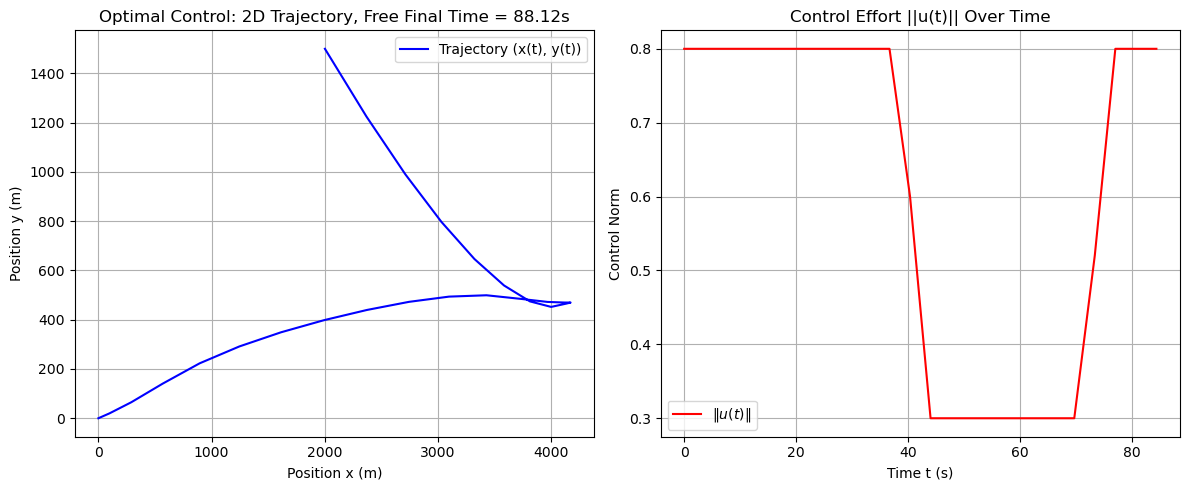

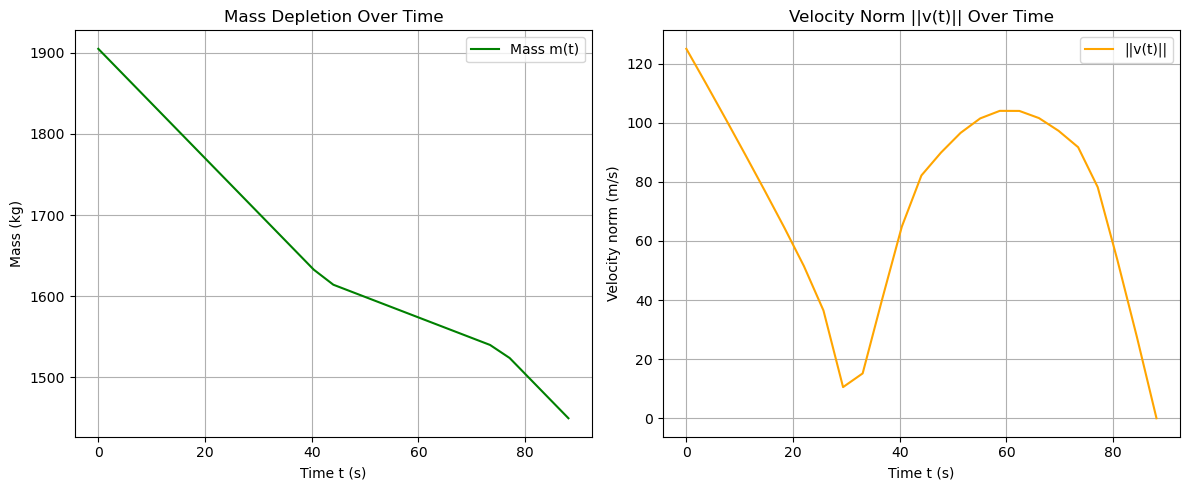

In [77]:
# Extract and plot the solution

X3 = solution3.x
x_opt3 = X3[0:N]
y_opt3 = X3[N:2*N]
vx_opt3 = X3[2*N:3*N]
vy_opt3 = X3[3*N:4*N]
m_opt3 = X3[4*N:5*N]
ux_opt3 = X3[5*N:6*N-1]
uy_opt3 = X3[6*N-1:-1]
tf_opt3 = X3[-1]
dt = tf_opt3 / (N - 1)

# Compute control norm u_norm
u_norm3 = np.zeros(N-1)
for i in range(N-1):
    u_norm3[i] = # COMPLETE THE CODE

# Compute velocity norm v_norm
v_norm3 = np.zeros(N)
for i in range(N):
    v_norm3[i] = # COMPLETE THE CODE

# Print cost value
total_control_effort3 = np.sum(u_norm3 * dt)  # Euler sum approximation
print(f"Total Control Effort (Cost Value): {total_control_effort3:.4f}")

# Time vector
t3 = np.linspace(0, tf_opt3, N)

plt.figure(figsize=(12, 5))

# Plot trajectory
plt.subplot(1, 2, 1)
plt.plot(x_opt3, y_opt3, label='Trajectory (x(t), y(t))', color='blue')
plt.xlabel('Position x (m)')
plt.ylabel('Position y (m)')
plt.title(f'Optimal Control: 2D Trajectory, Free Final Time = {tf_opt3:.2f}s')
plt.grid(True)
plt.legend()

# Plot control norm ||u(t)||
plt.subplot(1, 2, 2)
plt.plot(t3[:-1], u_norm3, label=r'$\| u(t) \|$', color='red')
plt.xlabel('Time t (s)')
plt.ylabel('Control Norm')
plt.title('Control Effort ||u(t)|| Over Time')
plt.grid(True)
plt.legend()

# Show both plots
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))

# Plot mass over time
plt.subplot(1, 2, 1)
plt.plot(t3, m_opt3, label='Mass m(t)', color='green')
plt.xlabel('Time t (s)')
plt.ylabel('Mass (kg)')
plt.title('Mass Depletion Over Time')
plt.grid(True)
plt.legend()

# Plot velocity over time
plt.subplot(1, 2, 2)
plt.plot(t3, v_norm3, label='||v(t)||', color='orange')
plt.xlabel('Time t (s)')
plt.ylabel('Velocity norm (m/s)')
plt.title('Velocity Norm ||v(t)|| Over Time')
plt.grid(True)
plt.legend()

# Show both plots
plt.tight_layout()
plt.show()